In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Problem Description

This project is inspired by the Kaggle competition "I'm Something of a Painter Myself." It focuses on building a comprehensive training pipeline for a CycleGAN model to perform image style transfer between real-world photographs and paintings in the style of Claude Monet. The goal is to demonstrate advanced unsupervised machine learning techniques for artistic image translation.

To accomplish this, a Generative Adversarial Network (GAN) is trained to:

Learn and replicate the unique characteristics of Monet's painting style

Apply that style convincingly to photographic images

The dataset for this project is provided in two formats:

TFRecord (.tfrec) – optimized for use with TensorFlow

JPEG (.jpg) – standard image file format

As part of the project objectives, we aim to generate between 7,000 and 10,000 images rendered in Monet’s artistic style.

## Setup

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#%%capture
#!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from kaggle_datasets import KaggleDatasets

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
%matplotlib inline

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn

In [ ]:
print(tf.__version__)

## Load Data and Exploratory Data Analysis (EDA)

In [ ]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = "/kaggle/input/gan-getting-started"
#GCS_PATH = KaggleDatasets().get_gcs_path()

In [ ]:
monet_files= tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_files= tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [ ]:
print('No. of Monet TFRecord files: ',len(monet_files))
print('No. of Photo TFRecord files: ',len(photo_files))

In [ ]:
IMAGE_SIZE= [256,256]      
#This function is designed to preprocess image data encoded in JPEG format
#It takes a JPEG-encoded image as input and decodes it into a tensor with three color channels (RGB)
def decode_img(image):                                           
    image= tf.image.decode_jpeg(image,channels= 3)
    image= (tf.cast(image, tf.float32)/255)*2 -1
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])
    return image

#This function reads and parses data from a TensorFlow Record (TFRecord) file
def read_tfrec(example):
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format)
    image= decode_img(example['image'])
    return image

def load_data(files):
    data= tf.data.TFRecordDataset(files)
    data= data.map(read_tfrec)
    return data

In [ ]:
monet_data= load_data(monet_files).batch(1)                     
photo_data= load_data(photo_files).batch(1)

In [ ]:
train_monet = monet_data
train_photo = photo_data.take(300)
test_photo = photo_data.skip(300)

In [ ]:
sample_photo = next(iter(train_photo))
sample_monet = next(iter(train_monet))

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.show()

# Model Architecture
We are implementina a **CycleGAN** model, which is a type of Generative Adversarial Network (GAN) used primarily for image-to-image translation tasks. The CycleGAN architecture typically includes generators and two discriminators:

**Generators** convert images from one domain to another (e.g., photos to Monet paintings and vice versa). Discriminators distinguish between real and generated images for each domain.

We'll also define upsample and downsample functions using Conv2D and Conv2DTranspose layers, which are crucial for the generators in CycleGAN. downsample and upsample Functions: These functions build parts of the neural network that either reduce or increase the dimensions of the input image respectively. They are essential building blocks for creating the generator models in a GAN architecture.

**Model Compilation**: Model will be compiled with optimizers and loss functions for both the generators and discriminators. The losses include binary cross-entropy for discrimination tasks and additional cycle-consistency loss to ensure that the input image, after a round-trip conversion (photo to Monet to photo), resembles the original image.

## Models

In [ ]:
OUTPUT_CHANNELS = 3

## CycleGAN

In [ ]:
class CycleGAN(keras.Model):                       # CycleGAN class inheriting from keras.Model class so that it can use its methods to train, compile etc.
    def __init__(                                  # arguments to be passed in a CycleGAN class object   
        self,
        monet_gen,
        monet_disc,
        photo_gen,
        photo_disc,
        lambda_cycle= 10                           # 'lambda_cycle' controls the importance of cycle consistency loss
    ):
        super(CycleGAN,self).__init__()            # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen= monet_gen                      # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_disc= monet_disc
        self.p_gen= photo_gen
        self.p_disc= photo_disc
        self.lambda_cycle= lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile()             # calls the 'compile' fn of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):                                # automatically invoked when fit() method is called 
        real_monet, real_photo= batch_data
        
        with tf.GradientTape(persistent= True) as tape:             # to keep a track of operations (persistent= True bcz of multiple calls to Gradient())
            
            fake_monet= self.m_gen(real_photo, training= True)      # photo to monet and then cycled back to photo
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)      # monet to photo and then cycled back to monet
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      # generating itself (useful in calculating identity loss)
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   # discriminator used to check by inputing real images
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   # discriminator used to check by inputing fake images
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    # generator loss
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     # total cycle consistency loss
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                    # total generator monet loss
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    # total generator photo loss
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                      # discriminator monet loss 
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      # discriminator photo loss
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)            # calculate gradients for generators
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            # diff loss fn wrt trainable variables of model
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               # calculate gradients for discriminators
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      # apply the gradients to optimizer
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      # basically performing gradient descent
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

## Model#1

Based on architecture described earlier, let us build first model

In [ ]:
# for extracting important features (size is reduced)
def downsample(filters, size, instance_norm= True):                                   
    initializer= tf.random_normal_initializer(0,0.02)                                
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()                                          
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
    
    if instance_norm:
        # groups= -1: Instance Normalization
         model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))     
   
    model.add(LeakyReLU())
    
    return model

# for locating features accurately using skip connections
def upsample(filters, size, dropout= False):             
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False))
    model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))
    
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())
    
    return model

In [ ]:
def generator():
    down_stack= [
        downsample(64,4,False),                 
        downsample(128,4),                      
        downsample(256,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
    ]
    
    up_stack= [
        upsample(512,4,True),                   
        upsample(512,4,True),                   
        upsample(512,4,True),                   
        upsample(512,4),                        
        upsample(256,4),                        
        upsample(128,4),                        
        upsample(64,4)                          
    ]
    
    initializer= tf.random_normal_initializer(0,0.02)
    last_layer= Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= initializer, activation= 'tanh')     
    # input layer
    i= Input(shape= [256,256,3])                
    x= i
    skips= []
    # downsampling
    for down in down_stack:                     
        x= down (x) 
        skips.append(x)
        
    # last skip connection is not used because of alignment with upsampling path
    skips= reversed(skips[:-1])                 
    # upsampling and concatenating output with skip connection
    for up, skip in zip(up_stack,skips):        
        x= up (x)
        x= Concatenate() ([x,skip])
        
    # last layer (Conv2DTranspose) for generating the final output 
    x= last_layer(x)                            
    
    model= Model(i,x)
    
    return model

In [ ]:
#determine if an image is real or fake
def discriminator():
    i= Input(shape= [256,256,3])
    x= downsample(64,4) (i)                                 
    x= downsample(128,4) (x)                                
    x= downsample(256,4) (x)                                
    
    x= ZeroPadding2D() (x)                                  
    
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    x= Conv2D(512, 4, strides= 1, padding= 'same', kernel_initializer= initializer, use_bias= False) (x)
    x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    x= LeakyReLU() (x)
    
    x= ZeroPadding2D() (x)                                  
    
    x= Conv2D(1, 4, strides= 1, padding= 'same', kernel_initializer= initializer) (x)
                                                                                     
    model= Model(i,x)                                                                
    
    return model

In order to build the CycleGAN, we need four optimizers:

In [ ]:
# photo to monet-esque
monet_generator= generator()                     
# to differentiate between generated monet-esque images and real monet-esque images
monet_discriminator= discriminator()             
# monet-esque to photo
photo_generator= generator()                     
# to differentiate between generated 'normal' images and real 'normal' images
photo_discriminator= discriminator()   

# won't generate monet-esque photos as we have not fit the data into generator yet
photo_to_monet= monet_generator(sample_photo)                

plt.subplot(1,2,1)                                       
plt.title('Original Photo')
plt.imshow(sample_photo[0]*0.5 +0.5)                     

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)  

In [ ]:
# loss function for the generator
def gen_loss_fn(generated):            
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

# loss function for the discriminator
def disc_loss_fn(real, generated):
    loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
    total_loss= (loss_real + loss_fake)/2
        
    return total_loss

# loss for the cycle consistency
def cycle_loss_fn(real, cycled, lambda_cycle):
    loss= tf.reduce_mean(tf.abs(real - cycled))
        
    return lambda_cycle*loss  


def identity_loss_fn(real, same, Lambda):           
    loss= tf.reduce_mean(tf.abs(real - same))
    # factor of '0.5' used for normalization purposes
    return Lambda*loss*0.5   

Optimizers

In [ ]:
monet_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
monet_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

photo_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
photo_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

Build and Fit First Model:

In [ ]:
cyclegan_model1= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model1.compile(monet_gen_opt, monet_disc_opt, photo_gen_opt, photo_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [ ]:
cyclegan_model1.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 20)

## Model#2

Some minor changes like changing ReLU to ELU for Upsampling and parameter in Conv2D layer in discriminator

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def downsample(filters, size, apply_norm=True):
    """Downsamples an input."""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    """Upsamples an input."""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ELU())  # Changed from ReLU to ELU

    return result

#generate new image
def generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_norm=False),  # First layer, no normalization
        downsample(128, 4),  # Increasing the depth a bit
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),  # More dropout
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # Output layer

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#determine if an image is real or fake
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = downsample(64, 4, False)(inp)  # No normalization on the first layer
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    x = layers.ZeroPadding2D()(x)

    x = layers.Conv2D(512, 4, strides=1,
                      padding='same',
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU()(x)

    x = layers.ZeroPadding2D()(x)

    # Additional small kernel conv layer for detailed resolution adjustments
    x = layers.Conv2D(1, 2, strides=1, padding='same', kernel_initializer=initializer)(x) 

    return keras.Model(inputs=inp, outputs=x)

Instantiate both generators and discriminators

In [ ]:
# photo to monet-esque
monet_generator= generator()                     
# to differentiate between generated monet-esque images and real monet-esque images
monet_discriminator= discriminator()             
# monet-esque to photo
photo_generator= generator()                     
# to differentiate between generated 'normal' images and real 'normal' images
photo_discriminator= discriminator()   

In [ ]:
# won't generate monet-esque photos as we have not fit the data into generator yet
photo_to_monet= monet_generator(sample_photo)                

plt.subplot(1,2,1)                                       
plt.title('Original Photo')
plt.imshow(sample_photo[0]*0.5 +0.5)                     

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)     

Loss Functions


In [ ]:
def gen_loss_fn(generated):            
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

def disc_loss_fn(real, generated):
    loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
    total_loss= (loss_real + loss_fake)/2
        
    return total_loss

def cycle_loss_fn(real, cycled, lambda_cycle):
    loss= tf.reduce_mean(tf.abs(real - cycled))
        
    return lambda_cycle*loss  


def identity_loss_fn(real, same, Lambda):           
    loss= tf.reduce_mean(tf.abs(real - same))
    # factor of '0.5' used for normalization purposes
    return Lambda*loss*0.5 

Optimizers

In order to build the CycleGAN, we need four optimizers:

In [ ]:
monet_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
monet_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

photo_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
photo_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

### Build and Fit Model#2

In [ ]:
cyclegan_model2= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model2.compile(monet_gen_opt, monet_disc_opt, photo_gen_opt, photo_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [ ]:
cyclegan_model2.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 20)

## Model#3

We'd try a little different loss functions and optimizer parameters

Loss Function Differences

**discriminator** :

Uses a hinge loss variant where tf.nn.relu is used to ensure the discriminator has a margin of 1 for classifying real and fake images. It is a different approach than binary cross-entropy we used earlier, focusing on maximizing the margin between the classification of real and fake.

**generator:**

Directly negates the mean of the discriminator’s outputs on generated images, encouraging the generator to produce images that the discriminator evaluates as highly realistic.

Basically we are moving from binary cross-entropy for the generator and discriminator losses tried earlier to hinge loss and direct negation.

We also include a gradient penalty, which is a regularization method. This can help in the stability of the discriminator.


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

def discriminator_loss(real, fake):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake))
    return real_loss + fake_loss

def generator_loss(fake):
    return -tf.reduce_mean(fake)

def gradient_penalty(f, real, fake):
    alpha = tf.random.normal([real.shape[0], 1, 1, 1], 0.0, 1.0)
    diff = fake - real
    interp = real + alpha * diff
    
    with tf.GradientTape() as tape:
        tape.watch(interp)
        pred = f(interp)
    grad = tape.gradient(pred, [interp])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.) ** 2)
    return gp

def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * cycle_loss

def identity_loss(real_image, same_image, lambda_id=5):
    id_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_id * id_loss * 0.5  # Normalization factor

# Adjustments to the optimizer parameters
m_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
m_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)

p_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
p_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)

# Compile and train the model
cyclegan_model3= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model3.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt,
                       generator_loss, discriminator_loss, cycle_loss, identity_loss)

In [ ]:
cyclegan_model3.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs=40)

## Submit part

In [ ]:
fig,ax= plt.subplots(6,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(6)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

## Model#3

We'd try a little different loss functions and optimizer parameters

Loss Function Differences

discriminator :

Uses a hinge loss variant where tf.nn.relu is used to ensure the discriminator has a margin of 1 for classifying real and fake images. It is a different approach than binary cross-entropy we used earlier, focusing on maximizing the margin between the classification of real and fake.

generator:

Directly negates the mean of the discriminator’s outputs on generated images, encouraging the generator to produce images that the discriminator evaluates as highly realistic.

Basically we are moving from binary cross-entropy for the generator and discriminator losses tried earlier to hinge loss and direct negation.

We also include a gradient penalty, which is a regularization method. This can help in the stability of the discriminator.

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

def discriminator_loss(real, fake):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake))
    return real_loss + fake_loss

def generator_loss(fake):
    return -tf.reduce_mean(fake)

def gradient_penalty(f, real, fake):
    alpha = tf.random.normal([real.shape[0], 1, 1, 1], 0.0, 1.0)
    diff = fake - real
    interp = real + alpha * diff
    
    with tf.GradientTape() as tape:
        tape.watch(interp)
        pred = f(interp)
    grad = tape.gradient(pred, [interp])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.) ** 2)
    return gp

def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * cycle_loss

def identity_loss(real_image, same_image, lambda_id=5):
    id_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_id * id_loss * 0.5  # Normalization factor

# Adjustments to the optimizer parameters
m_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
m_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)

p_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
p_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)

# Compile and train the model
cyclegan_model3= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model3.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt,
                       generator_loss, discriminator_loss, cycle_loss, identity_loss)

In [ ]:
cyclegan_model3.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs=40)

In [ ]:
#!rm -r ../images

In [ ]:
import PIL
!mkdir ../images

In [ ]:
i = 1
for image in photo_data:
    pred = monet_generator(image, training=False)[0].numpy()
    pred = (pred*127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Results and Analysis

I experimented with several variations during the project. Compared to some of the other topics covered in this course, my familiarity with CycleGAN was more limited, which constrained the range of modifications I could explore. However, I made an effort to thoroughly understand the loss functions, and found that tweaking them significantly improved the model's performance—particularly in Model #3.

The best-performing model, Model #3, corresponds to Version #3 of my submissions on Kaggle, as shown in the attached image below.

![](http://)

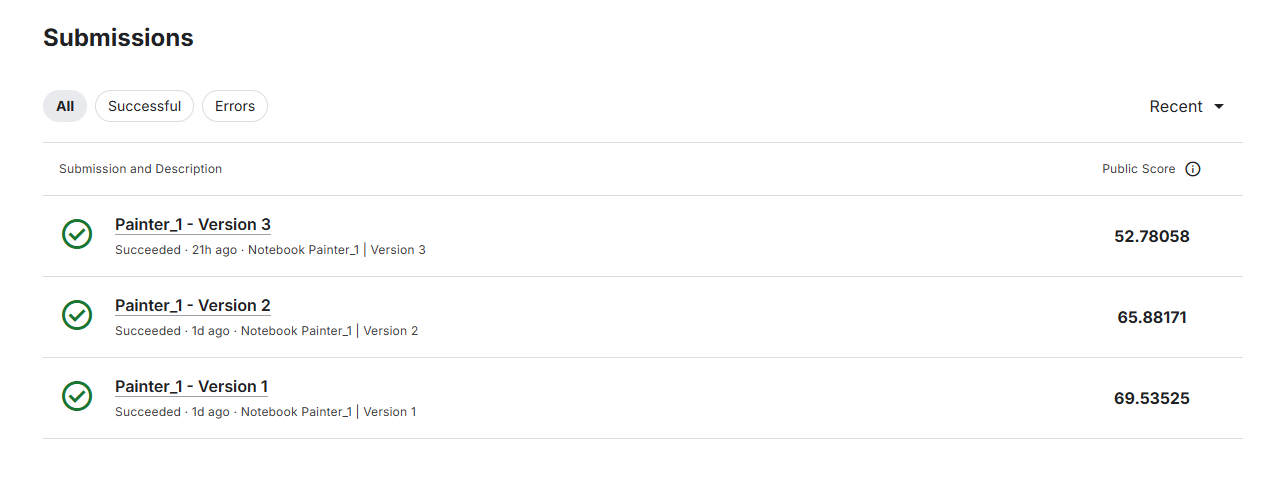

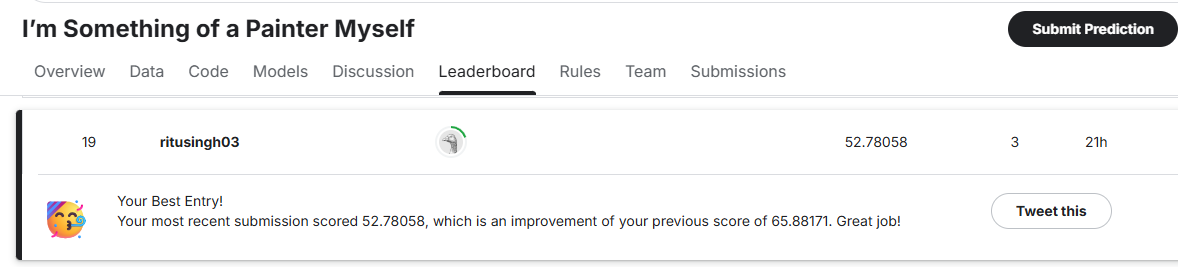

# Conclusion

CycleGAN is a complex model that requires extensive tuning to achieve optimal results. However, I was pleasantly surprised by the quality of the outcomes I achieved with just a few epochs and some targeted modifications.

In the future, I would like to explore the following improvements:

* Deepen my understanding of the model to identify effective variations and enhancements

* Experiment with different image preprocessing techniques to help the model converge more efficiently

* Apply a grid search or similar approach to systematically tune hyperparameters



# Github Repo Link

[Git Repo](https://github.com/ritusingh2020/dtsa511-kaggle-painter.git)